<a href="https://colab.research.google.com/github/kinan-02/SkinCancer-AL/blob/main/Stratiges/uncertinty_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
from collections import defaultdict
import argparse
from matplotlib import pyplot as plt
import random
import torch
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_df = pd.read_csv('train_dataset/metadata.csv')
test_df = pd.read_csv('test_dataset/metadata.csv')
val_df = pd.read_csv('validation_dataset/metadata.csv')

In [ ]:
print(train_df['diagnosis'].value_counts())

diagnosis
nevus                         1205
melanoma                      1113
pigmented benign keratosis    1099
basal cell carcinoma           514
squamous cell carcinoma        197
vascular lesion                142
actinic keratosis              130
dermatofibroma                 115
Name: count, dtype: int64


In [ ]:
class_mapping = {
    "actinic keratosis": 0,
    "basal cell carcinoma": 1,
    "dermatofibroma": 2,
    "melanoma": 3,
    "nevus": 4,
    "pigmented benign keratosis": 5,
    "squamous cell carcinoma": 6,
    "vascular lesion":7
}
class_mapping

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'squamous cell carcinoma': 6,
 'vascular lesion': 7}

In [ ]:
from PIL import Image
import os

import torchvision.transforms as transforms

# Define image transformations (resize, convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize images to 224x224 (matching ResNet input size)
    transforms.ToTensor()
])

# we made this class to read the data from the file and to use it later in the dataloader
class Dataset():
    def __init__(self, dataframe, transform, train='train'):
        self.dataframe=dataframe
        self.train = train
        self.transform = transform
        self.path_to_image=self._create_path_to_image_dict()
        self.paths=list(self.path_to_image.keys())
        self.labels=list(self.path_to_image.values())

    def _create_path_to_image_dict(self):
      path_to_image={}
      for index,row in self.dataframe.iterrows():
        if self.train == 'train':
          img_path = os.path.join('train_dataset/',row['isic_id']+'.jpg')
        elif self.train == 'test':
          img_path = os.path.join('test_dataset/',row['isic_id']+'.jpg')
        else:
            img_path = os.path.join('validation_dataset/',row['isic_id']+'.jpg')
        label=row['diagnosis']
        path_to_image[img_path]=label
      return path_to_image

    def __len__(self):
        return len(self.paths)

    def __getitem__(self,index):
        img_path=self.paths[index]
        img_label=self.labels[index]
        image=Image.open(img_path)
        image=self.transform(image)
        if self.train == 'val':
            return image, class_mapping[img_label], index
        return image, img_label, index

In [ ]:
train_df = Dataset(train_df, transform)
val_df = Dataset(val_df, transform,train='val')
test_df = Dataset(test_df, transform,train='test')

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.optim import Adam

# Load pre-trained ResNet50 model from torchvision
base_model = models.resnet50(pretrained=True)

num_classes = 8
base_model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(base_model.fc.in_features, 128),  # Add a fully connected layer
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Final layer with number of classes
    nn.Softmax(dim=1)  # Softmax activation for multi-class classification
)

for param in base_model.parameters():
    param.requires_grad = False  # Freeze all layers except the fully connected ones

# Unfreeze the final fully connected layer
for param in base_model.fc.parameters():
    param.requires_grad = True

loss_f = nn.CrossEntropyLoss()
optimizer = Adam(base_model.fc.parameters(), lr=0.0008)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)
x = 5

/anaconda/envs/py38_default/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 4
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=False)

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
from transformers import ViTFeatureExtractor, ViTModel

class ActiveLearningPipeline:
    def __init__(self, model,
                 available_pool_indices,
                 train_indices,
                 test_indices,
                 selection_criterion,
                 iterations,
                 budget_per_iter,
                 num_epochs):
        self.model = model
        self.iterations = iterations
        self.budget_per_iter = budget_per_iter
        self.available_pool_indices = available_pool_indices
        self.train_indices = train_indices
        self.test_indices = test_indices
        self.selection_criterion = selection_criterion
        if self.selection_criterion == 'random':
          self.train_indices = []
        self.num_epochs = num_epochs
        # self.best_acc = 0
        self.pool_features = []
        self.pool_indices = []

    def run_pipeline(self):
        """
        Run the active learning pipeline
        :return
        accuracy_scores: list, accuracy scores at each iteration
        """
        accuracy_scores = []
        self._get_features()
        for iteration in range(self.iterations):
            print(f"--------- Number of Iteration {iteration} ---------")
            if self.selection_criterion == 'random':
                self._random_sampling()
            elif self.selection_criterion == 'uncertainty_kmeans':
                self._uncertainty_kmeans_sampling(iteration)
            else:
              self._custom_sampling(iteration)

            train_images = [train_df.__getitem__(index)[0] for index in self.train_indices]
            label_df = [class_mapping[train_df.__getitem__(index)[1]] for index in self.train_indices]
            self._train_model(train_images, label_df)
            self.model.load_state_dict(torch.load(f"best_{self.selection_criterion}_model.pth"))
            accuracy = self._evaluate_model()
            accuracy_scores.append(accuracy)
        return accuracy_scores

    def calculate_class_weights(self, label_counts, num_classes=8):
      """
      calculate class weights to handle data imbalance for the loss function.
      """
        total_samples = sum(label_counts.values())
        class_weights = torch.zeros(num_classes)

        for cls in range(num_classes):
            if cls in label_counts:
                class_weights[cls] = total_samples / (num_classes * label_counts[cls])
            else:
                class_weights[cls] = 1.0

        return class_weights

    def _train_model(self, train_images, label_df):
      """
      This function trains the base model on the provided training set and saves the best-performing model.
      """
      label_counts = defaultdict(int)
      for label in label_df:
                label_counts[label] += 1
      class_weights = self.calculate_class_weights(label_counts, 8).to(device)
      loss_f = nn.CrossEntropyLoss(weight=class_weights)

      train_images_tensor = torch.stack(train_images)
      label_df_tensor = torch.tensor(label_df)
      train_dataset = TensorDataset(train_images_tensor, label_df_tensor)

      batch_size = 32
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      best_acc = 0
      for epoch in range(self.num_epochs):
                self.model.train()
                running_loss = 0.0  # Track the running loss
                correct_predictions = 0
                total_predictions = 0
                # Training loop
                for inputs, labels in train_loader:
                    inputs = inputs
                    inputs= inputs.to(device)
                    labels = torch.tensor(labels).to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = self.model(inputs)
                    loss = loss_f(outputs, labels)

                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

                    # Calculate accuracy
                    _, preds = torch.max(outputs, 1)
                    correct_predictions += torch.sum(preds == labels)
                    total_predictions += inputs.shape[0]

                # Print loss and accuracy at the end of each epoch
                epoch_loss = running_loss / len(train_loader)
                epoch_acc = correct_predictions.double() / total_predictions
                print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

                val_acc = self._check_model()
                if val_acc > best_acc:
                    best_acc = val_acc
                    torch.save(self.model.state_dict(), f"best_{self.selection_criterion}_model.pth")
      print("--"*30)

    def _check_model(self):
      """
      Returns the accuracy of the base model on the validation set.
      """
        self.model.eval()
        running_corrects = 0
        total_predictions = 0.0

        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels)
                total_predictions += inputs.shape[0]
        val_acc = running_corrects.double() / total_predictions
        return val_acc.item()

    def _evaluate_model(self):
        """
        Returns the accuracy of the base model on the test set.
        """
        self.model.eval()
        running_corrects = 0
        test_images_tensor = torch.stack(test_images)
        label_df_tensor = torch.tensor(test_label_df)
        test_dataset = TensorDataset(test_images_tensor, label_df_tensor)
        batch_size = 32  # Adjust based on your memory and hardware
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        total_predictions = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels)
                total_predictions += inputs.shape[0]
        test_acc = running_corrects.double() / total_predictions
        return test_acc.item()

    def _random_sampling(self):
      """
      Adds samples to the training set using a random sampling strategy.
      """
      selected_indices = np.random.choice(self.available_pool_indices, self.budget_per_iter, replace=False)
      selected_indices = selected_indices.tolist()
      self.train_indices = self.train_indices + selected_indices

      available_pool_set = set(self.available_pool_indices)
      train_set = set(self.train_indices)
      self.available_pool_indices = list(available_pool_set - train_set)


    def extract_vae_features(self, dataloader, model, feature_extractor):
        """
        Return the latent vector for each image and the corresponding indices.
        """
        features_list = []
        indices_list = []

        with torch.no_grad():
            for images, indices in dataloader:
                # images = images.to(device)  # Move images to GPU if available
                images_list = [transforms.ToPILImage()(img) for img in images]
                inputs = feature_extractor(images=images_list, return_tensors="pt")
                with torch.no_grad():
                    outputs = model(**inputs)

                x = outputs.last_hidden_state[:, 0, :]
                features_list.append(x.cpu().numpy())

                # Collect indices
                indices_list.extend(indices)

        # Stack all features into a 2D array (n_samples, hidden_dim)
        features = np.vstack(features_list)

        return features, indices_list


    def get_representative_images(self, kmeans, pool_features, pool_indices):
          """
         returns a dictionary where the keys are the index of the cluster and the values are the closest images to
         each centroid note that the K of the KMeans is the budget per iteration.
        """
        cluster_to_images = {}
        for i in range(kmeans.n_clusters):
            # Get the indices of all images in the current cluster
            cluster_indices = np.where(kmeans.labels_ == i)[0]

            # Extract features of the images in the current cluster
            cluster_features = pool_features[cluster_indices]

            # Compute distances between each feature and the cluster centroid
            distances = np.linalg.norm(cluster_features - kmeans.cluster_centers_[i], axis=1)

            # Map the cluster number to the index of the representative image
            nearest_indices = cluster_indices[np.argsort(distances)[:1]]


            # Map the cluster number to the indices of the top k nearest images
            cluster_to_images[i] = [pool_indices[idx] for idx in nearest_indices]

        return cluster_to_images

    def _get_features(self):
      """
      Creates latent feature vectors for each image in the available pool using a pre-trained Vision Transformer (ViT) model from Google.
      """
        feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
        model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

        X_unlabeled = [train_df.__getitem__(index)[0] for index in self.available_pool_indices]
        # Extract latent features using the VAE model
        pool_images_tensor = torch.stack(X_unlabeled)
        pool_indices_tensor = torch.tensor(self.available_pool_indices)
        pool_dataset = TensorDataset(pool_images_tensor, pool_indices_tensor)

        batch_size = 32
        pool_loader = DataLoader(pool_dataset, batch_size=batch_size, shuffle=False)

        self.pool_features, self.pool_indices = self.extract_vae_features(pool_loader, model, feature_extractor)

    def _kmean_uncertin_samples(self, selected_indices):
      """
      returns the selected indices
      """
        n_clusters = self.budget_per_iter
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0)
        kmeans.fit(self.pool_features[selected_indices])

        pool_indices_np = np.array(self.pool_indices)
        representative_images = self.get_representative_images(kmeans, self.pool_features[selected_indices], pool_indices_np[selected_indices])
        selected_indices = list(ids.item() for l in representative_images.values() for ids in l)

        for i in selected_indices:
              index = self.pool_indices.index(i)
              self.pool_features = np.delete(self.pool_features, index, axis=0)
              self.pool_indices.pop(index)
        return selected_indices

    def _uncertainty_kmeans_sampling(self, itr):
      """
      Adds samples to the training set using a uncertainty-kmeans sampling strategy.
      """
      model = self.model

      X_unlabeled = [train_df.__getitem__(index)[0] for index in self.available_pool_indices]

      pool_images_tensor = torch.stack(X_unlabeled)
      pool_dataset = TensorDataset(pool_images_tensor)

      batch_size = 32
      pool_loader = DataLoader(pool_dataset, batch_size=batch_size, shuffle=False)
      model.eval()
      outputs = []
      with torch.no_grad():
                for inputs in pool_loader:
                    inputs = inputs[0]
                    inputs = inputs.to(device)
                    x = model(inputs)
                    if x.shape[0] != batch_size:
                        padding_tensor = torch.full((batch_size - x.shape[0], 8), 0).to(device)
                        c = batch_size - x.shape[0]
                        x = torch.cat([x, padding_tensor])
                    outputs.append(x)
      probabilities = torch.cat(outputs, dim=0)
      probabilities = probabilities[:-c]
      probabilities_cpu = probabilities.cpu().numpy()
      uncertainties = entropy(probabilities_cpu, axis=1)

      selected_indices = np.argsort(uncertainties)[-(self.budget_per_iter*self.iterations):]

      selected_indices = self._kmean_uncertin_samples(selected_indices)

      self.train_indices = self.train_indices + selected_indices

      available_pool_set = set(self.available_pool_indices)
      train_set = set(self.train_indices)
      self.available_pool_indices = list(available_pool_set - train_set)


In [ ]:
def generate_plot(accuracy_scores_dict):
    """
    Generate a plot
    """
    for criterion, accuracy_scores in accuracy_scores_dict.items():
        plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, label=criterion)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
available_pool_indices = []
for i in range(len(train_df)):
  """ Initialize the available pool indices """
    image, label, index = train_df[i]
    available_pool_indices.append(index)

test_indices = []
for i in range(len(test_df)):
  """ Initialize the  test set """
    image, label, index = test_df[i]
    test_indices.append(index)

# Extract the images and labels for the collected test indices
test_images = [test_df.__getitem__(index)[0] for index in test_indices]
test_label_df = [class_mapping[test_df.__getitem__(index)[1]] for index in test_indices]

In [ ]:
# This is the initial training set extracted using KMeans++ clustering with ViT (Vision Transformer) feature extraction.
train_indices = [1372,
 1277,
 1255,
 1423,
 2925,
 1963,
 2335,
 1923,
 3791,
 1239,
 909,
 134,
 1547,
 3931,
 2467,
 2832,
 1789,
 3022,
 2424,
 780,
 2412,
 3038,
 2158,
 3335,
 1868,
 1771,
 2015,
 1535,
 710,
 3007]
available_pool_set = set(available_pool_indices)
train_set = set(train_indices)
available_pool_indices = list(available_pool_set - train_set)

In [ ]:
# train_indices = []
iterations = 20
budget_per_iter = 60
num_epoch = 15
selection_criteria = ['uncertainty_kmeans']
accuracy_scores_dict = defaultdict(list)
model = base_model

/anaconda/envs/py38_default/lib/python3.9/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


--------- Number of Iteration 0 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 2.0915, Accuracy: 0.1111


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 2.0637, Accuracy: 0.2444
Epoch [3/15], Loss: 2.0343, Accuracy: 0.2889
Epoch [4/15], Loss: 1.9987, Accuracy: 0.4222
Epoch [5/15], Loss: 1.9534, Accuracy: 0.5111
Epoch [6/15], Loss: 1.9010, Accuracy: 0.5889
Epoch [7/15], Loss: 1.8471, Accuracy: 0.6111
Epoch [8/15], Loss: 1.7989, Accuracy: 0.5444
Epoch [9/15], Loss: 1.7316, Accuracy: 0.6333
Epoch [10/15], Loss: 1.6892, Accuracy: 0.6667
Epoch [11/15], Loss: 1.6717, Accuracy: 0.7111
Epoch [12/15], Loss: 1.6204, Accuracy: 0.7778
Epoch [13/15], Loss: 1.5838, Accuracy: 0.7889
Epoch [14/15], Loss: 1.5654, Accuracy: 0.8333
Epoch [15/15], Loss: 1.5196, Accuracy: 0.8222
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 1 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.7922, Accuracy: 0.6067


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.7900, Accuracy: 0.5933
Epoch [3/15], Loss: 1.7641, Accuracy: 0.6133
Epoch [4/15], Loss: 1.7225, Accuracy: 0.6133
Epoch [5/15], Loss: 1.6758, Accuracy: 0.6333
Epoch [6/15], Loss: 1.6924, Accuracy: 0.6400
Epoch [7/15], Loss: 1.6425, Accuracy: 0.6667
Epoch [8/15], Loss: 1.6028, Accuracy: 0.7067
Epoch [9/15], Loss: 1.5848, Accuracy: 0.6867
Epoch [10/15], Loss: 1.5675, Accuracy: 0.7467
Epoch [11/15], Loss: 1.5503, Accuracy: 0.7267
Epoch [12/15], Loss: 1.4977, Accuracy: 0.7800
Epoch [13/15], Loss: 1.4936, Accuracy: 0.7867
Epoch [14/15], Loss: 1.4870, Accuracy: 0.8267
Epoch [15/15], Loss: 1.5002, Accuracy: 0.7867
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 2 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5934, Accuracy: 0.6571


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5742, Accuracy: 0.6667
Epoch [3/15], Loss: 1.5522, Accuracy: 0.7190
Epoch [4/15], Loss: 1.5498, Accuracy: 0.7333
Epoch [5/15], Loss: 1.5399, Accuracy: 0.7190
Epoch [6/15], Loss: 1.5121, Accuracy: 0.7381
Epoch [7/15], Loss: 1.5102, Accuracy: 0.7476
Epoch [8/15], Loss: 1.4972, Accuracy: 0.7333
Epoch [9/15], Loss: 1.4940, Accuracy: 0.7524
Epoch [10/15], Loss: 1.4768, Accuracy: 0.7905
Epoch [11/15], Loss: 1.4639, Accuracy: 0.7952
Epoch [12/15], Loss: 1.4571, Accuracy: 0.7952
Epoch [13/15], Loss: 1.4608, Accuracy: 0.7905
Epoch [14/15], Loss: 1.4285, Accuracy: 0.8238
Epoch [15/15], Loss: 1.4231, Accuracy: 0.8143
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 3 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5812, Accuracy: 0.7074


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6077, Accuracy: 0.6963
Epoch [3/15], Loss: 1.5727, Accuracy: 0.7037
Epoch [4/15], Loss: 1.5767, Accuracy: 0.7593
Epoch [5/15], Loss: 1.5497, Accuracy: 0.7444
Epoch [6/15], Loss: 1.5431, Accuracy: 0.7556
Epoch [7/15], Loss: 1.5207, Accuracy: 0.7519
Epoch [8/15], Loss: 1.5353, Accuracy: 0.7444
Epoch [9/15], Loss: 1.5157, Accuracy: 0.7926
Epoch [10/15], Loss: 1.5024, Accuracy: 0.7704
Epoch [11/15], Loss: 1.4786, Accuracy: 0.8370
Epoch [12/15], Loss: 1.4931, Accuracy: 0.7852
Epoch [13/15], Loss: 1.4847, Accuracy: 0.8222
Epoch [14/15], Loss: 1.4845, Accuracy: 0.8000
Epoch [15/15], Loss: 1.4725, Accuracy: 0.8111
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 4 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6207, Accuracy: 0.7212


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5778, Accuracy: 0.6636
Epoch [3/15], Loss: 1.6154, Accuracy: 0.6879
Epoch [4/15], Loss: 1.5653, Accuracy: 0.7424
Epoch [5/15], Loss: 1.5623, Accuracy: 0.7455
Epoch [6/15], Loss: 1.5462, Accuracy: 0.7485
Epoch [7/15], Loss: 1.5289, Accuracy: 0.7485
Epoch [8/15], Loss: 1.5166, Accuracy: 0.7545
Epoch [9/15], Loss: 1.5230, Accuracy: 0.7758
Epoch [10/15], Loss: 1.5009, Accuracy: 0.7879
Epoch [11/15], Loss: 1.5199, Accuracy: 0.7758
Epoch [12/15], Loss: 1.4936, Accuracy: 0.7879
Epoch [13/15], Loss: 1.4827, Accuracy: 0.7939
Epoch [14/15], Loss: 1.4910, Accuracy: 0.8030
Epoch [15/15], Loss: 1.5072, Accuracy: 0.7788
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 5 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6155, Accuracy: 0.6769


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5870, Accuracy: 0.6692
Epoch [3/15], Loss: 1.6486, Accuracy: 0.6282
Epoch [4/15], Loss: 1.6599, Accuracy: 0.6128
Epoch [5/15], Loss: 1.5923, Accuracy: 0.7000
Epoch [6/15], Loss: 1.5793, Accuracy: 0.7256
Epoch [7/15], Loss: 1.5418, Accuracy: 0.7308
Epoch [8/15], Loss: 1.5614, Accuracy: 0.7308
Epoch [9/15], Loss: 1.5532, Accuracy: 0.7410
Epoch [10/15], Loss: 1.5624, Accuracy: 0.7128
Epoch [11/15], Loss: 1.4980, Accuracy: 0.7744
Epoch [12/15], Loss: 1.4935, Accuracy: 0.7795
Epoch [13/15], Loss: 1.5216, Accuracy: 0.7641
Epoch [14/15], Loss: 1.5159, Accuracy: 0.7846
Epoch [15/15], Loss: 1.4663, Accuracy: 0.7795
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 6 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6084, Accuracy: 0.6956


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6509, Accuracy: 0.6533
Epoch [3/15], Loss: 1.6305, Accuracy: 0.5844
Epoch [4/15], Loss: 1.7000, Accuracy: 0.5244
Epoch [5/15], Loss: 1.6318, Accuracy: 0.6511
Epoch [6/15], Loss: 1.5915, Accuracy: 0.6444
Epoch [7/15], Loss: 1.6032, Accuracy: 0.6911
Epoch [8/15], Loss: 1.5443, Accuracy: 0.7111
Epoch [9/15], Loss: 1.5548, Accuracy: 0.7400
Epoch [10/15], Loss: 1.4944, Accuracy: 0.7444
Epoch [11/15], Loss: 1.5203, Accuracy: 0.7222
Epoch [12/15], Loss: 1.5316, Accuracy: 0.7689
Epoch [13/15], Loss: 1.5816, Accuracy: 0.6200
Epoch [14/15], Loss: 1.5843, Accuracy: 0.5889
Epoch [15/15], Loss: 1.4914, Accuracy: 0.7800
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 7 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.7001, Accuracy: 0.5255


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6568, Accuracy: 0.6353
Epoch [3/15], Loss: 1.5875, Accuracy: 0.6863
Epoch [4/15], Loss: 1.6084, Accuracy: 0.6686
Epoch [5/15], Loss: 1.5733, Accuracy: 0.7020
Epoch [6/15], Loss: 1.5473, Accuracy: 0.7196
Epoch [7/15], Loss: 1.5435, Accuracy: 0.7353
Epoch [8/15], Loss: 1.5640, Accuracy: 0.6824
Epoch [9/15], Loss: 1.5538, Accuracy: 0.7235
Epoch [10/15], Loss: 1.5332, Accuracy: 0.7294
Epoch [11/15], Loss: 1.5235, Accuracy: 0.7059
Epoch [12/15], Loss: 1.5170, Accuracy: 0.7275
Epoch [13/15], Loss: 1.5126, Accuracy: 0.7529
Epoch [14/15], Loss: 1.5172, Accuracy: 0.7373
Epoch [15/15], Loss: 1.5002, Accuracy: 0.7686
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 8 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5684, Accuracy: 0.6754


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5674, Accuracy: 0.7035
Epoch [3/15], Loss: 1.5887, Accuracy: 0.6579
Epoch [4/15], Loss: 1.5292, Accuracy: 0.7246
Epoch [5/15], Loss: 1.5488, Accuracy: 0.7018
Epoch [6/15], Loss: 1.5341, Accuracy: 0.7158
Epoch [7/15], Loss: 1.5171, Accuracy: 0.7281
Epoch [8/15], Loss: 1.5179, Accuracy: 0.7456
Epoch [9/15], Loss: 1.5175, Accuracy: 0.7316
Epoch [10/15], Loss: 1.4959, Accuracy: 0.7649
Epoch [11/15], Loss: 1.4899, Accuracy: 0.7702
Epoch [12/15], Loss: 1.4822, Accuracy: 0.7789
Epoch [13/15], Loss: 1.5449, Accuracy: 0.6842
Epoch [14/15], Loss: 1.4957, Accuracy: 0.7456
Epoch [15/15], Loss: 1.4978, Accuracy: 0.7789
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 9 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5833, Accuracy: 0.6667


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5554, Accuracy: 0.7032
Epoch [3/15], Loss: 1.5682, Accuracy: 0.6825
Epoch [4/15], Loss: 1.5473, Accuracy: 0.6968
Epoch [5/15], Loss: 1.5695, Accuracy: 0.6762
Epoch [6/15], Loss: 1.5799, Accuracy: 0.6413
Epoch [7/15], Loss: 1.5276, Accuracy: 0.7270
Epoch [8/15], Loss: 1.5172, Accuracy: 0.7460
Epoch [9/15], Loss: 1.5138, Accuracy: 0.7429
Epoch [10/15], Loss: 1.5251, Accuracy: 0.7143
Epoch [11/15], Loss: 1.5339, Accuracy: 0.7016
Epoch [12/15], Loss: 1.5115, Accuracy: 0.7444
Epoch [13/15], Loss: 1.4948, Accuracy: 0.7698
Epoch [14/15], Loss: 1.4953, Accuracy: 0.7635
Epoch [15/15], Loss: 1.4917, Accuracy: 0.7714
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 10 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6100, Accuracy: 0.6623


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6082, Accuracy: 0.6246
Epoch [3/15], Loss: 1.5813, Accuracy: 0.6812
Epoch [4/15], Loss: 1.5873, Accuracy: 0.6725
Epoch [5/15], Loss: 1.5403, Accuracy: 0.7072
Epoch [6/15], Loss: 1.5646, Accuracy: 0.6928
Epoch [7/15], Loss: 1.5305, Accuracy: 0.7203
Epoch [8/15], Loss: 1.5595, Accuracy: 0.6725
Epoch [9/15], Loss: 1.5294, Accuracy: 0.7246
Epoch [10/15], Loss: 1.5113, Accuracy: 0.7348
Epoch [11/15], Loss: 1.5069, Accuracy: 0.7290
Epoch [12/15], Loss: 1.5128, Accuracy: 0.7478
Epoch [13/15], Loss: 1.4966, Accuracy: 0.7594
Epoch [14/15], Loss: 1.4990, Accuracy: 0.7406
Epoch [15/15], Loss: 1.5162, Accuracy: 0.7232
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 11 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5179, Accuracy: 0.7240


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5045, Accuracy: 0.7453
Epoch [3/15], Loss: 1.5281, Accuracy: 0.7013
Epoch [4/15], Loss: 1.5354, Accuracy: 0.7107
Epoch [5/15], Loss: 1.5004, Accuracy: 0.7387
Epoch [6/15], Loss: 1.5271, Accuracy: 0.7067
Epoch [7/15], Loss: 1.5068, Accuracy: 0.7427
Epoch [8/15], Loss: 1.5013, Accuracy: 0.7413
Epoch [9/15], Loss: 1.4995, Accuracy: 0.7347
Epoch [10/15], Loss: 1.4982, Accuracy: 0.7467
Epoch [11/15], Loss: 1.4898, Accuracy: 0.7547
Epoch [12/15], Loss: 1.4837, Accuracy: 0.7573
Epoch [13/15], Loss: 1.4898, Accuracy: 0.7547
Epoch [14/15], Loss: 1.4760, Accuracy: 0.7693
Epoch [15/15], Loss: 1.4559, Accuracy: 0.7907
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 12 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5313, Accuracy: 0.7222


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5241, Accuracy: 0.7284
Epoch [3/15], Loss: 1.5516, Accuracy: 0.6840
Epoch [4/15], Loss: 1.5503, Accuracy: 0.6988
Epoch [5/15], Loss: 1.5277, Accuracy: 0.7049
Epoch [6/15], Loss: 1.5372, Accuracy: 0.7025
Epoch [7/15], Loss: 1.5264, Accuracy: 0.7062
Epoch [8/15], Loss: 1.5091, Accuracy: 0.7222
Epoch [9/15], Loss: 1.5193, Accuracy: 0.7160
Epoch [10/15], Loss: 1.5150, Accuracy: 0.7346
Epoch [11/15], Loss: 1.5043, Accuracy: 0.7346
Epoch [12/15], Loss: 1.4942, Accuracy: 0.7469
Epoch [13/15], Loss: 1.4925, Accuracy: 0.7407
Epoch [14/15], Loss: 1.4917, Accuracy: 0.7333
Epoch [15/15], Loss: 1.4980, Accuracy: 0.7568
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 13 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5169, Accuracy: 0.7264


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5151, Accuracy: 0.7253
Epoch [3/15], Loss: 1.5201, Accuracy: 0.7138
Epoch [4/15], Loss: 1.4995, Accuracy: 0.7356
Epoch [5/15], Loss: 1.5005, Accuracy: 0.7621
Epoch [6/15], Loss: 1.5124, Accuracy: 0.7368
Epoch [7/15], Loss: 1.5107, Accuracy: 0.7241
Epoch [8/15], Loss: 1.4787, Accuracy: 0.7609
Epoch [9/15], Loss: 1.4749, Accuracy: 0.7782
Epoch [10/15], Loss: 1.5265, Accuracy: 0.7379
Epoch [11/15], Loss: 1.5597, Accuracy: 0.6667
Epoch [12/15], Loss: 1.5016, Accuracy: 0.7379
Epoch [13/15], Loss: 1.4833, Accuracy: 0.7448
Epoch [14/15], Loss: 1.5550, Accuracy: 0.5931
Epoch [15/15], Loss: 1.5018, Accuracy: 0.7057
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 14 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5532, Accuracy: 0.7022


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5684, Accuracy: 0.7043
Epoch [3/15], Loss: 1.5470, Accuracy: 0.7140
Epoch [4/15], Loss: 1.5036, Accuracy: 0.7441
Epoch [5/15], Loss: 1.5311, Accuracy: 0.7204
Epoch [6/15], Loss: 1.5280, Accuracy: 0.7215
Epoch [7/15], Loss: 1.5235, Accuracy: 0.7280
Epoch [8/15], Loss: 1.5064, Accuracy: 0.7473
Epoch [9/15], Loss: 1.6059, Accuracy: 0.5720
Epoch [10/15], Loss: 1.5546, Accuracy: 0.6817
Epoch [11/15], Loss: 1.6802, Accuracy: 0.4710
Epoch [12/15], Loss: 1.7405, Accuracy: 0.3806
Epoch [13/15], Loss: 1.6332, Accuracy: 0.5473
Epoch [14/15], Loss: 1.5241, Accuracy: 0.7290
Epoch [15/15], Loss: 1.5070, Accuracy: 0.7495
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 15 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5612, Accuracy: 0.6838


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5347, Accuracy: 0.7030
Epoch [3/15], Loss: 1.5391, Accuracy: 0.6990
Epoch [4/15], Loss: 1.5270, Accuracy: 0.7152
Epoch [5/15], Loss: 1.5315, Accuracy: 0.7010
Epoch [6/15], Loss: 1.5128, Accuracy: 0.7343
Epoch [7/15], Loss: 1.5236, Accuracy: 0.7172
Epoch [8/15], Loss: 1.5052, Accuracy: 0.7293
Epoch [9/15], Loss: 1.5102, Accuracy: 0.7141
Epoch [10/15], Loss: 1.5100, Accuracy: 0.7152
Epoch [11/15], Loss: 1.5029, Accuracy: 0.7303
Epoch [12/15], Loss: 1.4954, Accuracy: 0.7384
Epoch [13/15], Loss: 1.4847, Accuracy: 0.7545
Epoch [14/15], Loss: 1.5061, Accuracy: 0.7323
Epoch [15/15], Loss: 1.4776, Accuracy: 0.7818
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 16 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5329, Accuracy: 0.6924


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5252, Accuracy: 0.6990
Epoch [3/15], Loss: 1.5189, Accuracy: 0.7076
Epoch [4/15], Loss: 1.5116, Accuracy: 0.7267
Epoch [5/15], Loss: 1.5150, Accuracy: 0.7229
Epoch [6/15], Loss: 1.4994, Accuracy: 0.7362
Epoch [7/15], Loss: 1.4839, Accuracy: 0.7495
Epoch [8/15], Loss: 1.4886, Accuracy: 0.7476
Epoch [9/15], Loss: 1.4866, Accuracy: 0.7371
Epoch [10/15], Loss: 1.4875, Accuracy: 0.7524
Epoch [11/15], Loss: 1.4838, Accuracy: 0.7476
Epoch [12/15], Loss: 1.4830, Accuracy: 0.7581
Epoch [13/15], Loss: 1.4885, Accuracy: 0.7571
Epoch [14/15], Loss: 1.4673, Accuracy: 0.7610
Epoch [15/15], Loss: 1.4831, Accuracy: 0.7467
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 17 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5479, Accuracy: 0.6838


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5340, Accuracy: 0.6892
Epoch [3/15], Loss: 1.5294, Accuracy: 0.7045
Epoch [4/15], Loss: 1.5288, Accuracy: 0.6928
Epoch [5/15], Loss: 1.5087, Accuracy: 0.7387
Epoch [6/15], Loss: 1.5277, Accuracy: 0.7009
Epoch [7/15], Loss: 1.5073, Accuracy: 0.7162
Epoch [8/15], Loss: 1.5045, Accuracy: 0.7261
Epoch [9/15], Loss: 1.4955, Accuracy: 0.7351
Epoch [10/15], Loss: 1.5019, Accuracy: 0.7405
Epoch [11/15], Loss: 1.4983, Accuracy: 0.7396
Epoch [12/15], Loss: 1.4985, Accuracy: 0.7315
Epoch [13/15], Loss: 1.5002, Accuracy: 0.7342
Epoch [14/15], Loss: 1.4949, Accuracy: 0.7432
Epoch [15/15], Loss: 1.4941, Accuracy: 0.7315
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 18 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5232, Accuracy: 0.7120


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5217, Accuracy: 0.7128
Epoch [3/15], Loss: 1.5042, Accuracy: 0.7419
Epoch [4/15], Loss: 1.5033, Accuracy: 0.7214
Epoch [5/15], Loss: 1.5102, Accuracy: 0.7239
Epoch [6/15], Loss: 1.4890, Accuracy: 0.7393
Epoch [7/15], Loss: 1.4957, Accuracy: 0.7444
Epoch [8/15], Loss: 1.5019, Accuracy: 0.7291
Epoch [9/15], Loss: 1.5123, Accuracy: 0.7068
Epoch [10/15], Loss: 1.5042, Accuracy: 0.7325
Epoch [11/15], Loss: 1.4972, Accuracy: 0.7342
Epoch [12/15], Loss: 1.4862, Accuracy: 0.7385
Epoch [13/15], Loss: 1.4721, Accuracy: 0.7615
Epoch [14/15], Loss: 1.5003, Accuracy: 0.7342
Epoch [15/15], Loss: 1.4856, Accuracy: 0.7487
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 19 ---------


/tmp/ipykernel_443073/3868758775.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5142, Accuracy: 0.7195


/tmp/ipykernel_443073/3868758775.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5040, Accuracy: 0.7317
Epoch [3/15], Loss: 1.5033, Accuracy: 0.7472
Epoch [4/15], Loss: 1.5167, Accuracy: 0.7228
Epoch [5/15], Loss: 1.4977, Accuracy: 0.7374
Epoch [6/15], Loss: 1.4850, Accuracy: 0.7512
Epoch [7/15], Loss: 1.4917, Accuracy: 0.7455
Epoch [8/15], Loss: 1.4788, Accuracy: 0.7593
Epoch [9/15], Loss: 1.4741, Accuracy: 0.7707
Epoch [10/15], Loss: 1.4694, Accuracy: 0.7724
Epoch [11/15], Loss: 1.4834, Accuracy: 0.7553
Epoch [12/15], Loss: 1.4623, Accuracy: 0.7724
Epoch [13/15], Loss: 1.4948, Accuracy: 0.7268
Epoch [14/15], Loss: 1.4729, Accuracy: 0.7675
Epoch [15/15], Loss: 1.4722, Accuracy: 0.7667
------------------------------------------------------------


/tmp/ipykernel_443073/3868758775.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


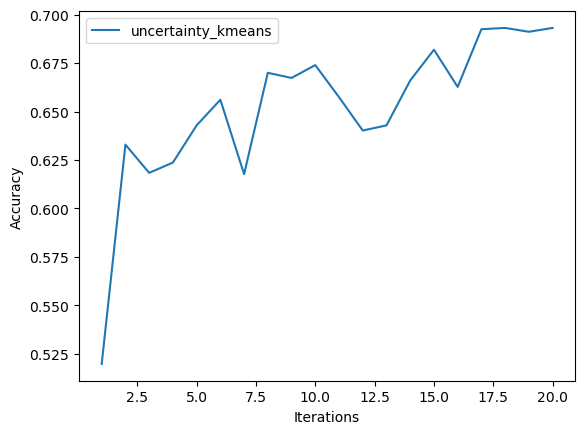

In [ ]:
for criterion in selection_criteria:
    AL_class = ActiveLearningPipeline(model=model,
                                      test_indices=test_indices,
                                      available_pool_indices=available_pool_indices,
                                      train_indices=train_indices,
                                      selection_criterion=criterion,
                                      iterations=iterations,
                                      budget_per_iter=budget_per_iter,
                                      num_epochs=num_epoch)
    accuracy_scores_dict[criterion] = AL_class.run_pipeline()
generate_plot(accuracy_scores_dict)

In [ ]:
accuracy_scores_dict

defaultdict(list,
            {'uncertainty_kmeans': [0.5198412698412698,
              0.6329365079365079,
              0.6183862433862434,
              0.6236772486772486,
              0.6428571428571428,
              0.656084656084656,
              0.6177248677248677,
              0.6699735449735449,
              0.6673280423280423,
              0.673941798941799,
              0.6574074074074073,
              0.6402116402116402,
              0.6428571428571428,
              0.6660052910052909,
              0.6818783068783069,
              0.6626984126984127,
              0.6924603174603174,
              0.693121693121693,
              0.691137566137566,
              0.693121693121693]})